# Pytorch Homework 3: 利用 stanford dog (mini) dataset 來訓練一個分類器。

## 作業說明

這次的作業總共有 4 個部份，必須完成助教提供的 ipynb 檔，在檔案中某些區塊會有 ??? 處需要完成。

0. 安裝需要使用的 package: pip install -r requirements.txt

1. 實作 Dataloader
    * 1.1. 實作一個可以讀取 stanford dog (mini) 的 Pytorch dataset。 ** (10%) **
    * 1.2. 將每一個類別以 8 : 2 的比例分割成 Training data 和 Testing data 傳至 dataloader  ** (15%) **

2. 建構 CNN model。
    * 2.1. 利用 Pytorch 內建的 CNN model 來進行訓練。 ** (10%) **
    * 2.2. 自行設計一個新的 CNN model 來進行訓練。 ** (20%) ** (至少達到 70% 以上的 Testing accuracy，否則只有一半的分數)
    * 2.3. 利用 torchsummary 來印出上面兩個模型的架構資訊。 ** (5%) **

3. 實作模型訓練和測試模型效能。 ** (30%) **
4. 將每一個 epoch 的 Loss 以及 Training / Testing accuracy 紀錄下來並繪製成圖並儲存下來。 ** (10%) **
    
## 作業繳交

* Deadline : 11/16 中午12:00        
    * **遲交一天打 7 折**
    * **遲交兩天打 5 折**
    * **遲交三天以上不給予分數**
    
* 繳交方式 : 請將完成的 ipynb 檔 (分成兩個版本: 內建 model 版和自己設計的版本) 以及 Loss、Training / testing accuracy 的圖片，壓縮後上傳至 moodle。
    * 建議先完成一個版本，然後將檔案複製後再完成另一個版本
    
* 壓縮檔內包含 :
    * (你的學號)\_(姓名)\_HW3_2_1.ipynb  (E.g.F77777777_王小明_HW3_2_1.ipynb) 
    * (你的學號)\_(姓名)\_HW3_2_2.ipynb  (E.g.F77777777_王小明_HW3_2_2.ipynb) 
    * 兩個版本的 Loss.png、Acc.png (Loss_2_1.png、Loss_2_2.png、Acc_2_1.png、Acc_2_2.png)
    * **格式不對的話會扣 10 分！！！**
    
* 有任何問題歡迎寄信至我的信箱
    * 曹維廷 a0903511820@gmail.com

In [110]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from torchsummary import summary

plt.ion()

In [111]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Part 1：Dataloader 實作

In [112]:
# 1.1. 填入 ??? 的部份
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:\\Users\\MarkYan\\OneDrive\\桌面\\Introduction_To_Artificial_Intelligence\\hw3\\stanford_dog'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Training', 'Testing']}
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['Training', 'Testing']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Training', 'Testing']}
class_names = image_datasets['Training'].classes

use_gpu = torch.cuda.is_available()


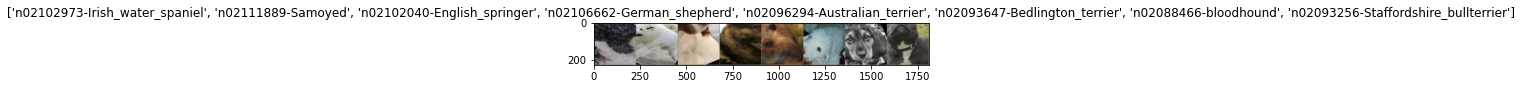

In [113]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloders['Training']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Part 2: 建立 CNN Model

In [114]:
# 2.2. 自行設計一個新的 CNN model

def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Testing']:
            if phase == 'Training':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'Training':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Testing' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model_ft.state_dict(),'optim':optimizer_ft.state_dict()}
                
        print()

    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

model_ft = models.resnet18(pretrained=True) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 120)

if use_gpu:
    model_ft = model_ft.cuda()
#model_ft = model_ft.float()
criterion = nn.CrossEntropyLoss()

### Setting

依據需求調整參數

In [115]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

### 3. 實作模型訓練和測試模型效能

In [116]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    

    for i, data in enumerate(dataloders['Testing']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        #print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.data, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return  

### 4. 將每一個 epoch 的 Loss 以及 Training / Testing accuracy 紀錄下來並繪製成圖。

In [102]:
model_ft = train_model(model_ft, criterion, optimizer_ft,num_epochs=20)

Epoch 0/19
----------
Training Loss: 0.5831 Acc: 0.0353
Testing Loss: 0.5049 Acc: 0.1621

Epoch 1/19
----------
Training Loss: 0.5064 Acc: 0.1470
Testing Loss: 0.3697 Acc: 0.3814

Epoch 2/19
----------
Training Loss: 0.4354 Acc: 0.2450
Testing Loss: 0.2823 Acc: 0.5024

Epoch 3/19
----------
Training Loss: 0.3878 Acc: 0.3077
Testing Loss: 0.2297 Acc: 0.5735

Epoch 4/19
----------
Training Loss: 0.3526 Acc: 0.3529
Testing Loss: 0.1921 Acc: 0.6260

Epoch 5/19
----------
Training Loss: 0.3294 Acc: 0.3828
Testing Loss: 0.1775 Acc: 0.6462

Epoch 6/19
----------
Training Loss: 0.3113 Acc: 0.4036
Testing Loss: 0.1586 Acc: 0.6772

Epoch 7/19
----------
Training Loss: 0.2983 Acc: 0.4180
Testing Loss: 0.1452 Acc: 0.6959

Epoch 8/19
----------
Training Loss: 0.2843 Acc: 0.4475
Testing Loss: 0.1362 Acc: 0.7064

Epoch 9/19
----------
Training Loss: 0.2772 Acc: 0.4542
Testing Loss: 0.1294 Acc: 0.7087

Epoch 10/19
----------
Training Loss: 0.2686 Acc: 0.4629
Testing Loss: 0.1249 Acc: 0.7227

Epoch 11/

In [109]:
summary(model_ft, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [ ]:
plt.figure()

plt.plot('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc)) # plot your loss

plt.title('Training Loss')
plt.ylabel('loss'), plt.xlabel('epoch')
plt.legend(['loss_C'], loc = 'upper left')
plt.show()

plt.figure()

plt.plot('Training complete in {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60)) # plot your training accuracy
plt.plot('Best val Acc: {:4f}'.format(best_acc)) # plot your testing accuracy

plt.title('Training acc')
plt.ylabel('acc (%)'), plt.xlabel('epoch')
plt.legend(['training acc', 'testing acc'], loc = 'upper left')
plt.show()